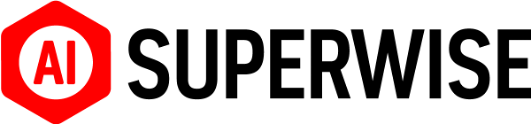

# **Example:  dsl-spa complex natural language interaction with a pandas dataframe**

This example shows that while natural language interaction with a dataset, i.e. a pandas dataframe or an sql database, can work fine for simple requests of the data, when queries become more complex a request to an LLM does not return a result.  [dsl-spa](https://github.com/superwise-ai/dsl-spa) is an open source capability that in addition to other capabilities addresses this problem.

In this example, we will interact with a simple dataframe using an LLM.  We will show the challenge with a complex query.  Then employ dsl-spa to address this challenge.  Let's get started!

#**Ask simple and more complex natural language questions of a Pandas Dataframe**

**Load the dataframe**
For this illustration we created a simple pandas dataframe that consists of look ups of letters in the alphabet and look ups of the phoenetic word for the alphabet.

In [1]:
import pandas as pd

In [2]:
alpha_phonetic_pd = pd.DataFrame({
    'col1' : [1,2,3,4,5,6,7,8,9,10],
    'col2' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'col3' : [10,9,8,7,6,5,4,3,2,1],
    'col4' : ['Juliett', 'India', 'Hotel', 'Gulf', 'Foxtrot', 'Echo', 'Delta', 'Charlie', 'Bravo', 'Alpha']
})

In [3]:
alpha_phonetic_pd.head()

,col1,col2,col3,col4
0,1,A,10,Juliett
1,2,B,9,India
2,3,C,8,Hotel
3,4,D,7,Gulf
4,5,E,6,Foxtrot


Using Pandas is outside the scope of this Example but there are easy things you can do with Pandas

In [5]:
#find the unique values for a particular column
alpha_phonetic_pd['col4'].unique()

array(['Juliett', 'India', 'Hotel', 'Gulf', 'Foxtrot', 'Echo', 'Delta',
       'Charlie', 'Bravo', 'Alpha'], dtype=object)

In [6]:
#get the maximum value for a particular column
alpha_phonetic_pd['col3'].max()

10

**Use a standard llm package to use natural language to ask questions**. In this case we will use Pandas AI and OpenAI for the LLM.  But, there are many packages and LLMs

In [7]:
!pip install "pandasai>=3.0.0b2" --quiet

In [8]:
import pandasai as pai
from pandasai_openai.openai import OpenAI

In [117]:
llm = OpenAI("<your_open_api_key")

In [10]:
pai.config.set({
    "llm": llm
})

In [12]:
#now lets load the same dataframe as a pandasAI dataframe
pai_alpha_phonetic_pd = pai.DataFrame({
    'col1' : [1,2,3,4,5,6,7,8,9,10],
    'col2' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'col3' : [10,9,8,7,6,5,4,3,2,1],
    'col4' : ['Juliett', 'India', 'Hotel', 'Gulf', 'Foxtrot', 'Echo', 'Delta', 'Charlie', 'Bravo', 'Alpha']
})

In [13]:
#Now lets ask some questions similar to the above
pai_alpha_phonetic_pd.chat("List the unique values in col4")

DataFrameResponse(type='dataframe', value=      col4
0    Alpha
1    Bravo
2  Charlie
3    Delta
4     Echo
5  Foxtrot
6     Gulf
7    Hotel
8    India
9  Juliett)

In [14]:
pai_alpha_phonetic_pd.chat("what is the largest number in Col3")

NumberResponse(type='number', value=10)

**Now lets add a pipeline of things**
For instance, in this case, I want to input a value from col1.  For whatever that value is, I want to find the same value in col3.  Then I want to return the value in col4 for the associated row.

In [15]:
#if you know pandas, you can write a function fairly easily to do this
def find_and_return_col4(df, col1_value):
  match_row = df[df['col3'] == col1_value]
  if not match_row.empty:
    return match_row['col4'].iloc[0]
  else:
    return None

In [16]:
#test out the function
find_and_return_col4(alpha_phonetic_pd, 1)

'Alpha'

In [17]:
#try using the llm
pai_alpha_phonetic_pd.chat("when col1 equals 1, what is the col4 row value where col3 equals col1")

StringResponse(type='string', value='')

In [18]:
#hmmm ok, that did not work, maybe I can try and ask the question in a better way
pai_alpha_phonetic_pd.chat("when col1 equals 1, what is the col4 row value")

StringResponse(type='string', value='Juliett')

In [19]:
#ok, that is worse, now it is giving a wrong answer

In [22]:
#let me try one more time
pai_alpha_phonetic_pd.chat("if col1 equals 1, what is the value in col4 when col3 equals col1")

StringResponse(type='string', value='No matching row found where col1=1 and col3=col1.')

In [23]:
#ok that is not true, let me try one more time
pai_alpha_phonetic_pd.chat("when col1 equals 1, for the col3 row number where the col1 value equals col3, what is the col4 value")

StringResponse(type='string', value='No matching col4 value found.')

**So for a simple query, an LLM worked fine, but for anything that required some type of pipeline of commands, even though a simple function in pandas would give the answer, I could not come up with natural language that the llm could use to generate that sequence**

**This is where dsl-spa comes in.  dsl-spa provides the ability for a data engineer to easily create a structure to answer known complex requirements while still using natural language as an interface**

#**Create the domain specific language and structured pipeline using dsl-spa**

**set up the dsl-spa structured pipeline**

In [24]:
!pip install dsl-spa --quiet

So, lets think what we are trying to do.  We want to be able to input a value.  In this case it is a value in col1.  If we have the col1 value that we can extract from natural language, then we can create a structured pipeline.  So, in this case, col1, is the field we need as input, and something we can easily extract from natural language using an LLM.  We will go back and create that agent further down in this notebook, but let's create that col1 field

In [25]:
#import the standard pipeline
from dsl_spa.pipeline.pipeline import StandardPipeline
from dsl_spa.utils.schema import PipelineField, StandardPipelineSchema

In [26]:
#define the field in dsl-spa
column_1 = PipelineField(field_name = "col1",
                         field_type = "string",
                         required = True,
                         description = "Input by the user")

In [27]:
#define the pipeline (we'll call it "My_Pipeline") and add that field to the pipeline we are going to use
pipeline = StandardPipelineSchema(pipeline_name = "My_Pipeline", fields = [column_1], datasets = [], queries = [], csvs = [], scope = "", scope_description = "")
pipeline.get_schema()

{'pipeline_name': 'My_Pipeline',
 'scope': '',
 'scope_description': '',
 'fields': {'base': {'col1': {'name': 'col1',
    'type': 'string',
    'required': True,
    'description': 'Input by the user'}}}}

So the above shows us our new dsl-spa pipeline called 'My_Pipeline' and we have a field called 'col1'

Let's test the pipeline by inputting a value and making sure it shows in the pipeline

In [28]:
from dsl_spa.pipeline.pipeline import StandardPipeline

In [29]:
#input a value of 5 for col1
my_schema = pipeline.get_schema()
my_practice_fields = {"col1" : 5}
my_pipeline = StandardPipeline(fields_input_dict = my_practice_fields, json_schema = my_schema, connectors = None, functions = None)
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
my_pipeline.get_field("base.col1")

5

Ok, cool, so now we see that when an Agent sets a field to "5", the structured pipeline will see that value for the field

Now lets add the data to the pipeline.  dsl-spa supports both a query and a csv as ways to add data to the pipeline.  Since we have a dataframe, we can easily write that to a csv that we can use

In [30]:
# prompt: write alpha_phonetic_pd to a csv
alpha_phonetic_pd.to_csv('alpha_phonetic.csv', index=False)

Now lets add that csv to our structured pipeline

In [31]:
from dsl_spa.utils.schema import CSV

In [32]:
csv = CSV(csv_name = "alpha_phonetic", connector_name = "csv_connector", filename = "alpha_phonetic.csv")
#no filter needed for this use case but could use to filter the data, this is useful in other scenarios
#csv.add_column_filter(field_name = "base.customer_name", column_name = "Customer", value = "{base.customer_name}")
csv.generate_schema()

{'name': 'alpha_phonetic',
 'connector': 'csv_connector',
 'csv_name': 'alpha_phonetic.csv'}

In [33]:
#add the csv schema to the pipeline
pipeline = StandardPipelineSchema(pipeline_name = "My_Pipeline", fields = [column_1], datasets = [], queries = [], csvs = [csv], scope = "", scope_description = "")
pipeline.get_schema()

{'pipeline_name': 'My_Pipeline',
 'scope': '',
 'scope_description': '',
 'fields': {'base': {'col1': {'name': 'col1',
    'type': 'string',
    'required': True,
    'description': 'Input by the user'}}},
 'csvs': [{'name': 'alpha_phonetic',
   'connector': 'csv_connector',
   'csv_name': 'alpha_phonetic.csv'}]}

Great.  Now lets connect the csv to that pipeline

In [34]:
from dsl_spa.pipeline.connector import LocalCSVConnector

In [35]:
#adding the csv and checking to see that it worked
connector = LocalCSVConnector(folder="./")
connector_dict = {"csv_connector": connector}
my_schema = pipeline.get_schema()
my_practice_fields = {"col1" : 5}
my_pipeline = StandardPipeline(fields_input_dict = my_practice_fields, json_schema = my_schema, connectors = connector_dict, functions = None)
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
print(my_pipeline.queries.keys()) # prints the name of the csvs/queries in the pipeline
my_pipeline.queries["alpha_phonetic"] # prints the dataframe of the csv

dict_keys(['alpha_phonetic'])


,col1,col2,col3,col4
0,1,A,10,Juliett
1,2,B,9,India
2,3,C,8,Hotel
3,4,D,7,Gulf
4,5,E,6,Foxtrot
5,6,F,5,Echo
6,7,G,4,Delta
7,8,H,3,Charlie
8,9,I,2,Bravo
9,10,J,1,Alpha


OK above you can see that we have one query called "alpha_phonetic".  And when you call it, it loads the dataframe from the alpha_phonetic.csv.  Cool.

Now that we have the input field and the data, we can add the function that returns the answer.  In dsl-spa the return may be more than an answer.  It might be a full set of data that can be summarized or visualized.  So the return is called a dataset.  So lets add the function that returns the dataset

In [36]:
#first for dsl-spa, we have to return a dataframe so let's modify the function slightly
def modified_find_and_return_col4(df, col1_value):
  match_row = df[df['col3'] == col1_value]
  return match_row

Just for clarity: The above function has two inputs, the df which will automatically be loaded by dsl-spa and then the col1_value which is our input field

In [37]:
from dsl_spa.utils.schema import SummaryDataset

Now in dsl-spa, we are create a dataset that returns the summary that in this case is the answer i.e. the row for col4

In [44]:
alpha_phonetic_dataset = SummaryDataset(dataset_name="alpha_phonetic_dataset", summary_by_row="{col4}", empty_dataset="Value not found")
alpha_phonetic_dataset.create_from_query("alpha_phonetic")
fields = {
    "col1_value": "base.col1"
}
alpha_phonetic_dataset.add_function(function_name="find_col_4_value", function_fields_dict=fields)
alpha_phonetic_dataset.generate_schema()

{'name': 'alpha_phonetic_dataset',
 'create': [{'type': 'query', 'name': 'alpha_phonetic'},
  {'type': 'function',
   'name': 'find_col_4_value',
   'fields': {'col1_value': 'base.col1'}}],
 'summarize': '{col4}',
 'remove_comma': False,
 'empty_summary': 'Value not found'}

Note: In the above you can see that the empty_summary is if the col1 value is not in the dataset

Ok great, now lets add this to pipeline schema

In [45]:
pipeline = StandardPipelineSchema(pipeline_name = "My_Pipeline", fields = [column_1], datasets = [alpha_phonetic_dataset], queries = [], csvs = [csv], scope = "", scope_description = "")
pipeline.get_schema()

{'pipeline_name': 'My_Pipeline',
 'scope': '',
 'scope_description': '',
 'fields': {'base': {'col1': {'name': 'col1',
    'type': 'string',
    'required': True,
    'description': 'Input by the user'}}},
 'csvs': [{'name': 'alpha_phonetic',
   'connector': 'csv_connector',
   'csv_name': 'alpha_phonetic.csv'}],
 'datasets': [{'name': 'alpha_phonetic_dataset',
   'create': [{'type': 'query', 'name': 'alpha_phonetic'},
    {'type': 'function',
     'name': 'find_col_4_value',
     'fields': {'col1_value': 'base.col1'}}],
   'summarize': '{col4}',
   'remove_comma': False,
   'empty_summary': 'Value not found'}]}

Now we can add the function and test it out by inserting a value for col1

In [46]:
my_schema = pipeline.get_schema()
my_practice_fields = {"col1" : 5}
my_pipeline = StandardPipeline(fields_input_dict = my_practice_fields, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
print(my_pipeline.datasets.keys())
my_pipeline.datasets["alpha_phonetic_dataset"]

dict_keys(['alpha_phonetic_dataset'])


,col1,col2,col3,col4
5,6,F,5,Echo


OK great we are getting the correct row as the returned, now lets just make sure the null works

In [47]:
#set col1 to 15 which is not a value in the dataset
my_schema = pipeline.get_schema()
my_practice_fields = {"col1" : 15}
my_pipeline = StandardPipeline(fields_input_dict = my_practice_fields, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
print(my_pipeline.datasets.keys())
my_pipeline.datasets["alpha_phonetic_dataset"]

dict_keys(['alpha_phonetic_dataset'])


,col1,col2,col3,col4


OK cool. Now we need to build the summary schema.  The summary assumes that there is more than one dataset because dsl-spa can return multiple datasets.  In this case there is only one, but that is why we have this step.

In [48]:
from dsl_spa.utils.schema import Summary

In [49]:
my_summary_answer = Summary(datasets=[alpha_phonetic_dataset])
my_summary_answer.generate_schema()

{'datasets': ['alpha_phonetic_dataset']}

And we can add that summary to the structured pipeline now

In [50]:
pipeline = StandardPipelineSchema(pipeline_name = "My_Pipeline", fields = [column_1], datasets = [alpha_phonetic_dataset], queries = [], csvs = [csv], scope = "", scope_description = "", summary=my_summary_answer)
pipeline.get_schema()

{'pipeline_name': 'My_Pipeline',
 'scope': '',
 'scope_description': '',
 'fields': {'base': {'col1': {'name': 'col1',
    'type': 'string',
    'required': True,
    'description': 'Input by the user'}}},
 'csvs': [{'name': 'alpha_phonetic',
   'connector': 'csv_connector',
   'csv_name': 'alpha_phonetic.csv'}],
 'datasets': [{'name': 'alpha_phonetic_dataset',
   'create': [{'type': 'query', 'name': 'alpha_phonetic'},
    {'type': 'function',
     'name': 'find_col_4_value',
     'fields': {'col1_value': 'base.col1'}}],
   'summarize': '{col4}',
   'remove_comma': False,
   'empty_summary': 'Value not found'}],
 'summary': {'datasets': ['alpha_phonetic_dataset']}}

Now we created the complete structured pipeline agent and we can test it out

In [51]:
my_schema = pipeline.get_schema()
my_practice_fields = {"col1" : 9}
my_pipeline = StandardPipeline(fields_input_dict = my_practice_fields, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
my_pipeline.get_summary()

'India'

And lets verify the null case

In [52]:
my_schema = pipeline.get_schema()
my_practice_fields = {"col1" : 19}
my_pipeline = StandardPipeline(fields_input_dict = my_practice_fields, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
my_pipeline.get_summary()

'Value not found'

So lets show how an output from an agent can call this structured pipeline agent.  I.e. test output from an agent now.  I.e. {
    "col1": 5,
    "pipeline": "my_pipeline"
}

In [98]:
output_from_agent = {
    "col1": 7,
    "pipeline": "my_pipeline"
}

In [99]:
output_from_agent

{'col1': 7, 'pipeline': 'my_pipeline'}

In [100]:
my_pipeline = StandardPipeline(fields_input_dict = output_from_agent, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
my_pipeline.get_summary()

'Gulf'

So, now that we have a structured pipeline agent, we can create an natural language agent to take in natural language and output the needed schema.  Let's use Superwise to do that

#**Create the Superwise Agent that will leverage the dsl-spa Structured Pipeline Agent**

Note this is a small subset of all you can do with Superwise.  
For complete Superwise capabilities visit: https://docs-swe.superwise.ai/

In [55]:
!pip install superwise-api --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00


In [56]:
import os
from superwise_api.superwise_client import SuperwiseClient

os.environ['SUPERWISE_CLIENT_ID'] = '<your_superwise_client_id>'
os.environ['SUPERWISE_CLIENT_SECRET'] = '<your_superwise_client_secret'

sw = SuperwiseClient()

In [57]:
#Create your agent to receive an application request for moon distance
from superwise_api.models.application.application import AdvancedAgentConfig

app = sw.application.create(
    name="Mark_dsl-spa_Example",
    additional_config=AdvancedAgentConfig(tools=[]),
    llm_model=None
)

In [58]:
#Add your choice of LLM to the Agent
from superwise_api.models.application.application import OpenAIModel, OpenAIModelVersion
from superwise_api.models.application.application import AdvancedAgentConfig

llm_model = OpenAIModel(version=OpenAIModelVersion.GPT_4, api_token="<your_open_api_key>")
app = sw.application.put(str(app.id),
                         additional_config=AdvancedAgentConfig(tools=[]),
                         llm_model=llm_model,
                         prompt=None,
                         name="Mark_dsl-spa_Example"
                        )

In [59]:
#test the connection to the agent
try:
    sw.application.test_model_connection(llm_model)
except Exception as e:
    print("Model test connection failed!")

print("Model test connection success!")

Model test connection success!


In [60]:
#test the agent
swe_answer = sw.application.ask_playground(
  input="What is the capital of France?",
  llm_model=llm_model,
  prompt="Just another promp",
  chat_history=[],
  additional_config=AdvancedAgentConfig(tools=[]) # Pass an AdvancedAgentConfig object
)
print(swe_answer)

output='The capital of France is Paris.' metadata=ResponseMetadata(cite_sources=None, debug_metadata=DebugMetadata(question='What is the capital of France?', answer='The capital of France is Paris.', start_time=datetime.datetime(2025, 7, 1, 20, 24, 55, 101553, tzinfo=TzInfo(UTC)), end_time=datetime.datetime(2025, 7, 1, 20, 24, 57, 321849, tzinfo=TzInfo(UTC)), intermediate_steps=[IntermediateStep(start_time=datetime.datetime(2025, 7, 1, 20, 24, 55, 116565), end_time=datetime.datetime(2025, 7, 1, 20, 24, 57, 318086), input_data='Human: You are an Assistant, respond to the human as helpfully and accurately as possible.\n\nTOOLS:\n------\n\nAssistant has access to the following tools, but it might also get zero tools in some cases, in which case you should just respond to the Human.\n\nHere are the tools that Assistant has access to, if this is empty, then Assistant has no tools to use:\n\n\n\nTo use a tool, please use the following format:\n\n```\nThought: Do I need to use a tool? Yes\nAc

In [101]:
#add a prompt to direct the output to be only what is needed for the dsl-spa agent
example_prompt = "You are an expert in finding a number value in a prompt.  Return the number in the following format: { 'col1': number, 'pipeline': 'my_pipeline' }. Only return that format and no other text."

In [102]:
#test the agent with the updated prompt
swe_answer = sw.application.ask_playground(
  input="What is the 8th value?",
  llm_model=llm_model,
  prompt=example_prompt,
  chat_history=[],
  additional_config=AdvancedAgentConfig(tools=[]) # Pass an AdvancedAgentConfig object
)
print(swe_answer)

output="{ 'col1': 8, 'pipeline': 'my_pipeline' }" metadata=ResponseMetadata(cite_sources=None, debug_metadata=DebugMetadata(question='What is the 8th value?', answer="{ 'col1': 8, 'pipeline': 'my_pipeline' }", start_time=datetime.datetime(2025, 7, 1, 21, 7, 21, 374982, tzinfo=TzInfo(UTC)), end_time=datetime.datetime(2025, 7, 1, 21, 7, 23, 432765, tzinfo=TzInfo(UTC)), intermediate_steps=[IntermediateStep(start_time=datetime.datetime(2025, 7, 1, 21, 7, 21, 384771), end_time=datetime.datetime(2025, 7, 1, 21, 7, 23, 430391), input_data="Human: You are an Assistant, respond to the human as helpfully and accurately as possible.\n\nTOOLS:\n------\n\nAssistant has access to the following tools, but it might also get zero tools in some cases, in which case you should just respond to the Human.\n\nHere are the tools that Assistant has access to, if this is empty, then Assistant has no tools to use:\n\n\n\nTo use a tool, please use the following format:\n\n```\nThought: Do I need to use a tool? Y

In [103]:
#this works in the playground, now lets use the deployed Superwise application
app = sw.application.put(str(app.id),
                         additional_config=AdvancedAgentConfig(tools=[]),
                         llm_model=llm_model,
                         prompt=example_prompt,
                         name="Mark_dsl-spa_Example"
                        )

In [118]:
#get the app id and the app token
app_id = sw.application.get(name="Mark_dsl-spa_Example").items[0].id
app_token = str(sw.application.get(name="Mark_dsl-spa_Example").items[0].api_token)
#print(app_id)
#print(app_token)

In [74]:
import requests
import json

In [92]:
def ask_application_via_api(app_id, user_input):
  endpoint_url = f"https://api.superwise.ai/v1/app-worker/{app_id}/v1/ask"

  #print(app_id)
  #print(user_input)
  #print(app_token)

  payload = {
    "chat_history": [],
    "input": user_input,
    #"prompt": prompt
  }

  headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "x-api-token": app_token
}

  resp = requests.post(endpoint_url, json=payload, headers=headers)
  app_response = resp.json()
  return app_response

In [104]:
ask_application_via_api(app_id, "What is the value associated with the input 6")["output"]

"{ 'col1': 6, 'pipeline': 'my_pipeline' }"

Lets see what we get when we input the text that the generic llm (pandas AI) to dataframe could not handle

In [105]:
ask_application_via_api(app_id, "when col1 equals 1, what is the col4 row value")["output"]

"{ 'col1': 1, 'pipeline': 'my_pipeline' }"

Good, lets try one of the other ones to make sure it still returns that structure

In [106]:
ask_application_via_api(app_id, "if col1 equals 1, what is the value in col4 when col3 equals col1")["output"]

"{ 'col1': 1, 'pipeline': 'my_pipeline' }"

#**Now simply flow the output of the Superwise Agent into dsl-spa**

In [80]:
# we need to convert the Superwise string output to JSON

In [107]:
# prompt: convert the output from ask_application_via_api from string to json

output_string = ask_application_via_api(app_id, "when col1 equals 1, what is the col4 row value")["output"]
print(output_string)
output_string = output_string.replace("'", '"')
print(output_string)
output_json = json.loads(output_string)
output_json


{ 'col1': 1, 'pipeline': 'my_pipeline' }
{ "col1": 1, "pipeline": "my_pipeline" }


{'col1': 1, 'pipeline': 'my_pipeline'}

In [ ]:
#{'col1': 7, 'pipeline': 'my_pipeline'}

In [109]:
input = "when col1 equals 1, what is the col4 row value"
#print(input)
output_from_superwise = ask_application_via_api(app_id, input)["output"]
output_from_superwise = output_from_superwise.replace("'", '"')
#print(output_from_superwise)
output_superwise_json = json.loads(output_from_superwise)
#print(output_superwise_json)
my_pipeline = StandardPipeline(fields_input_dict = output_superwise_json, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
# Runs the pipeline
my_pipeline.initialize_data()
my_pipeline.process_data()
my_pipeline.get_summary()

'Alpha'

Let's make it a little cleaner with a function

In [110]:
def input_with_agent_and_superwise(input):
  output_from_superwise = ask_application_via_api(app_id, input)["output"]
  output_from_superwise = output_from_superwise.replace("'", '"')
  output_superwise_json = json
  output_superwise_json = json.loads(output_from_superwise)
  my_pipeline = StandardPipeline(fields_input_dict = output_superwise_json, json_schema = my_schema, connectors = connector_dict, functions = {"find_col_4_value": modified_find_and_return_col4})
  my_pipeline.initialize_data()
  my_pipeline.process_data()
  return my_pipeline.get_summary()

In [113]:
new_input = "if col1 equals 10, what is the value in col4 when col3 equals col1"

In [114]:
input_with_agent_and_superwise(new_input)

'Juliett'

In [115]:
null_input = "what is the 14th one?"

In [116]:
input_with_agent_and_superwise(null_input)

'Value not found'

***That is it.  We overcame the challenge of complex queries while still leveraging natural language. But, there are lots more you can do with [dsl-spa](https://github.com/superwise-ai/dsl-spa) including generating summaries under which to ask follow on questions and generating visualizations from those summaries.  And there is a lot more you can do with [Superwise](https://docs-swe.superwise.ai/) including adding guardrails, setting policies, monitoring usage and getting alerts***